# Install Statements

In [54]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import cv2
from pathlib import Path
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import warnings
warnings.filterwarnings('ignore')

## Dependency Imcompactibility Fix

In [9]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 88.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


# Set random seed for reproducibility


In [17]:
np.random.seed(42)
tf.random.set_seed(42)


# Data paths


In [18]:
train_data_path = '/kaggle/input/cardiomegaly-disease-prediction-using-cnn/train/train'
test_data_path = '/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test'

# Verify dataset availability

In [21]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/tuberculosis-tb-chest-xray-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tuberculosis-tb-chest-xray-dataset



# Define data directories (update path as per your environment)

In [22]:
data_dir = Path('../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/')
normal_cases_dir = data_dir / 'Normal'
Tuberculosis_cases_dir = data_dir / 'Tuberculosis'

# Verify directories exist

In [23]:
if not normal_cases_dir.exists() or not Tuberculosis_cases_dir.exists():
    raise FileNotFoundError(f"Dataset directories not found. Check path: {data_dir}")

# Get image paths


In [24]:
normal_cases = list(normal_cases_dir.glob('*.png'))
Tuberculosis_cases = list(Tuberculosis_cases_dir.glob('*.png'))

print(f"Found {len(normal_cases)} normal images and {len(Tuberculosis_cases)} tuberculosis images.")

Found 3500 normal images and 700 tuberculosis images.


# Load images and labels


In [28]:
train_data = []
train_labels = []

In [29]:
for img_path in tqdm(normal_cases, desc="Loading Normal Images"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.resize(img, (28, 28))  # Resize to 28x28 for consistency
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])  # Convert grayscale to RGB if needed
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img) / 255.0  # Normalize pixel values to [0,1]
    train_data.append(img)
    train_labels.append(0)  # Label 0 for Normal

Loading Normal Images: 100%|██████████| 3500/3500 [01:11<00:00, 48.88it/s]


In [30]:
for img_path in tqdm(Tuberculosis_cases, desc="Loading Tuberculosis Images"):
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    img = cv2.resize(img, (28, 28))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img) / 255.0
    train_data.append(img)
    train_labels.append(1)  # Label 1 for Tuberculosis


Loading Tuberculosis Images: 100%|██████████| 700/700 [00:13<00:00, 52.42it/s]


# Convert to numpy arrays


In [31]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Check if data is loaded


In [32]:
if len(train_data) == 0:
    raise ValueError(f"No images were loaded. Check dataset path: {data_dir}")

In [33]:
print(f"Loaded {len(train_data)} images with shape {train_data.shape} and {len(train_labels)} labels.")

Loaded 4200 images with shape (4200, 28, 28, 3) and 4200 labels.


# Preprocessing Visualizations
# Display sample images

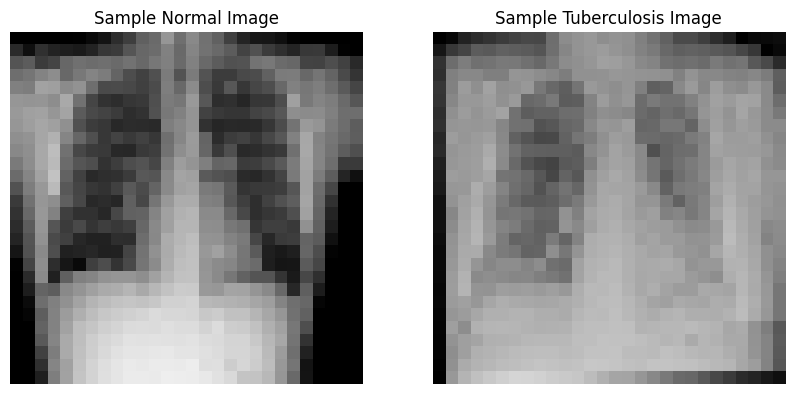

In [34]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_data[train_labels == 0][0])
plt.title('Sample Normal Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(train_data[train_labels == 1][0])
plt.title('Sample Tuberculosis Image')
plt.axis('off')
plt.show()

# Plot class distribution before SMOTE


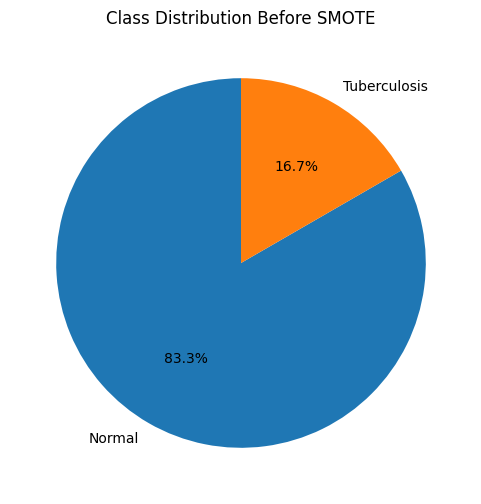

In [35]:
plt.figure(figsize=(6, 6))
labels = ['Normal', 'Tuberculosis']
sizes = [np.sum(train_labels == 0), np.sum(train_labels == 1)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution Before SMOTE')
plt.show()

# Apply SMOTE to balance classes


In [37]:
smt = SMOTE(random_state=42)
train_data_flat = train_data.reshape(len(train_data), -1)
train_data_flat, train_labels = smt.fit_resample(train_data_flat, train_labels)
train_data = train_data_flat.reshape(-1, 28, 28, 3)

print(f"After SMOTE: Normal: {np.sum(train_labels == 0)}, Tuberculosis: {np.sum(train_labels == 1)}")

After SMOTE: Normal: 3500, Tuberculosis: 3500


# Split data into training and test sets


In [38]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.13, random_state=42)

# Data augmentation for deep learning models to improve generalization

In [40]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Define Deep Learning Models


## Simple CNN: A lightweight model with basic convolutional layers

In [41]:
def create_simple_cnn():
    # Methodology: Basic CNN with few layers to serve as a baseline. Uses dropout for regularization.
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Prevents overfitting
        layers.Dense(2, activation='softmax')
    ])
    return model

## VGG-like: Deeper model inspired by VGGNet


In [42]:
def create_vgg_like_model():
    # Methodology: Multiple convolutional layers with small filters, followed by dense layers.
    # Customization: Adapted for 28x28 images, uses dropout for regularization.
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])
    return model

## ResNet-like: Incorporates residual connections


In [44]:
def create_resnet_like_model():
    # Methodology: Uses skip connections to mitigate vanishing gradients, allowing deeper networks.
    # Customization: Simplified for small input size with batch normalization for stability.
    inputs = keras.Input(shape=(28, 28, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x
        
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 64)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

## DenseNet-like: Features dense connectivity


In [45]:
def create_densenet_like_model():
    # Methodology: Each layer receives inputs from all previous layers, promoting feature reuse.
    # Customization: Reduced complexity for 28x28 images, uses batch normalization.
    inputs = keras.Input(shape=(28, 28, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    
    def dense_block(x, num_layers, filters):
        for _ in range(num_layers):
            bn = layers.BatchNormalization()(x)
            relu = layers.Activation('relu')(bn)
            conv = layers.Conv2D(filters, (3, 3), padding='same')(relu)
            x = layers.Concatenate()([x, conv])
        return x
    
    x = dense_block(x, 4, 16)
    x = layers.MaxPooling2D((2, 2))(x)
    x = dense_block(x, 4, 16)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

## Inception-like: Uses multiple filter sizes in parallel


In [46]:
def create_inception_like_model():
    # Methodology: Inception modules capture features at different scales.
    # Customization: Simplified for small images, uses dropout for regularization.
    inputs = keras.Input(shape=(28, 28, 3))
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    
    def inception_module(x, filters):
        branch1 = layers.Conv2D(filters, (1, 1), activation='relu')(x)
        branch3 = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        branch5 = layers.Conv2D(filters, (5, 5), activation='relu', padding='same')(x)
        branch_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = layers.Conv2D(filters, (1, 1), activation='relu')(branch_pool)
        x = layers.Concatenate()([branch1, branch3, branch5, branch_pool])
        return x
    
    x = inception_module(x, 16)
    x = layers.MaxPooling2D((2, 2))(x)
    x = inception_module(x, 32)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

# Define Traditional Machine Learning Models
## Random Forest: Ensemble of decision trees

### Methodology: Combines multiple trees for robust predictions. OOB score acts as a validation metric.
### Customization: Uses out-of-bag score instead of early stopping, suitable for non-iterative training.


In [47]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)

### XGBoost: Gradient boosting with early stopping


### Methodology: Builds trees sequentially, correcting previous errors. Supports early stopping.
### Customization: Configured with early stopping rounds to prevent overfitting.


In [48]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

## SVM: Support vector machine with RBF kernel


### Methodology: Finds optimal hyperplane with maximum margin. RBF kernel handles non-linear data.
### Customization: Probability estimates enabled for ROC-AUC calculation; scaling applied.

In [49]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# List of models to train (5 DL + 3 ML)


In [55]:
models_to_train = [
    (create_simple_cnn(), "Simple CNN", "DL"),
    (create_vgg_like_model(), "VGG-like", "DL"),
    (create_resnet_like_model(), "ResNet-like", "DL"),
    (create_densenet_like_model(), "DenseNet-like", "DL"),
    (create_inception_like_model(), "Inception-like", "DL"),
  
]


In [60]:
models_to_train_ml = [
      (rf_model, "Random Forest", "ML"),
    (xgb_model, "XGBoost", "ML"),
    (svm_model, "SVM", "ML"),
]

# Training and Evaluation Functions


In [52]:
def train_and_evaluate_dl(model, model_name, X_train, y_train, X_test, y_test):
    # Compile model with standard optimizer and loss function
    model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    # Early stopping to prevent overfitting, checkpoint to save best model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}.keras', save_best_only=True, monitor='val_accuracy')
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpoint], batch_size=32, verbose=1)
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_pred_proba = y_pred[:, 1]
    
    # Calculate performance metrics
    report = classification_report(y_test, y_pred_classes, target_names=['Normal', 'Tuberculosis'], output_dict=True)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print evaluation results
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_pred_classes, target_names=['Normal', 'Tuberculosis']))
    print(f"ROC AUC: {auc:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    return model, history, report, auc




# Train and evaluate all models



Training Simple CNN model...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7228 - loss: 0.5167 - val_accuracy: 0.9088 - val_loss: 0.2417
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8880 - loss: 0.2928 - val_accuracy: 0.8945 - val_loss: 0.2461
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9131 - loss: 0.2149 - val_accuracy: 0.9440 - val_loss: 0.1528
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9252 - loss: 0.1857 - val_accuracy: 0.9582 - val_loss: 0.1129
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9402 - loss: 0.1613 - val_accuracy: 0.9615 - val_loss: 0.1049
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9417 - loss: 0.1496 - val_accuracy: 0.9549 - val_loss: 0.1094
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9467 - loss: 0.1431 - val_accuracy: 0.9648 - val_loss: 0.0930
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9488 - l

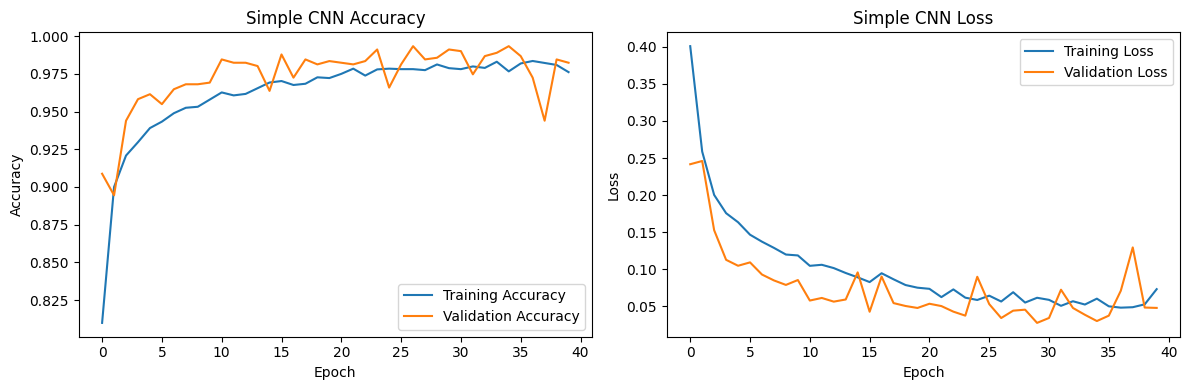

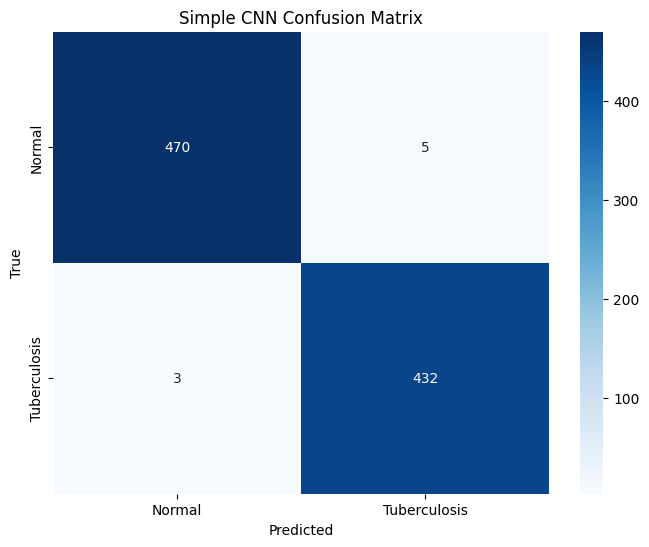

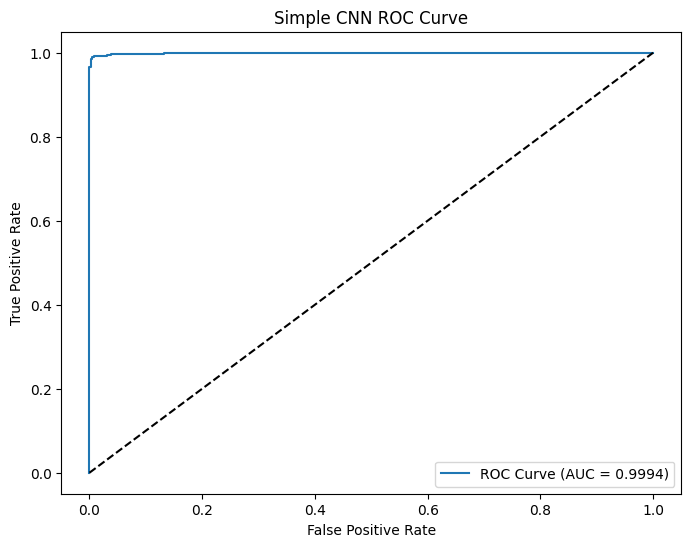

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Training VGG-like model...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6849 - loss: 0.5367 - val_accuracy: 0.9055 - val_loss: 0.2469
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9148 - loss: 0.2130 - val_accuracy: 0.9418 - val_loss: 0.1542
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9014 - loss: 0.2460 - val_accuracy: 0.9077 - val_loss: 0.2305
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9449 - loss: 0.1431 - val_accuracy: 0.9066 - val_loss: 0.2635
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9490 - loss: 0.1432 - val_accuracy: 0.9527 - val_loss: 0.1239
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9341 - loss: 0.1678 - val_accuracy: 0.9714 - val_loss: 0.0702
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9659 - loss: 0.1069 - val_accuracy: 0.9670 - val_loss: 0.0991
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━

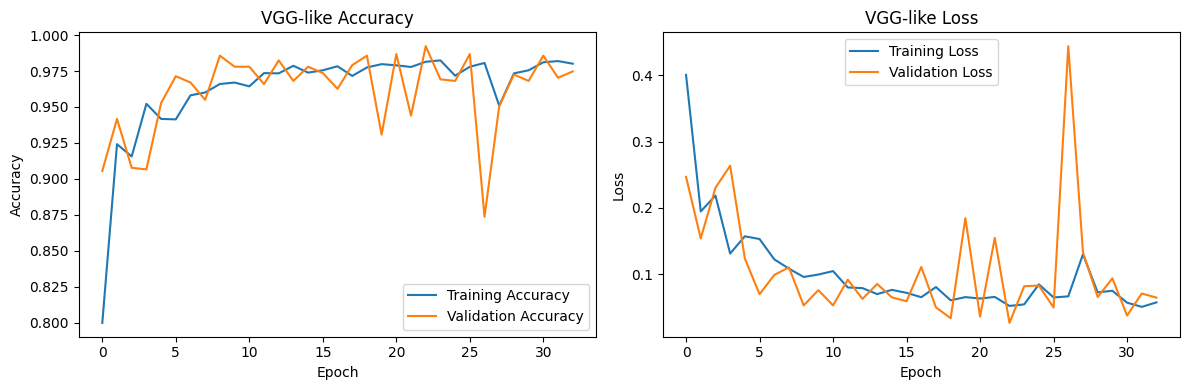

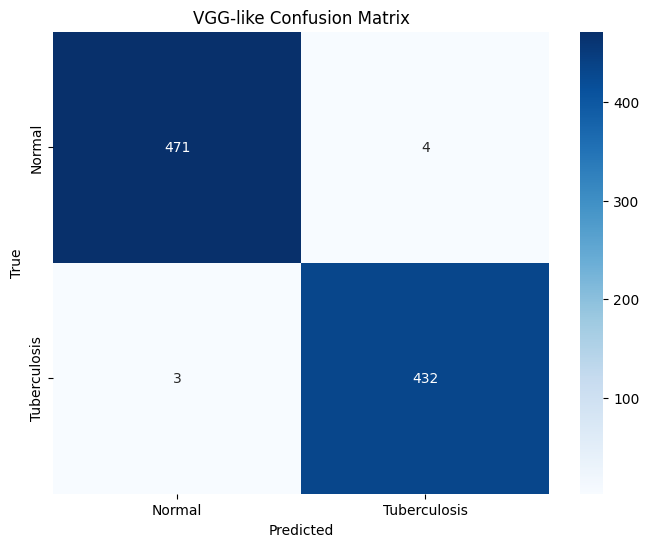

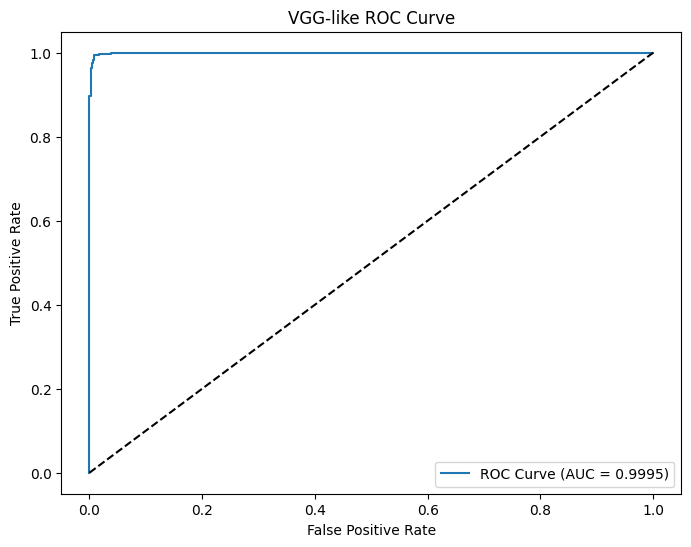

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Training ResNet-like model...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8250 - loss: 0.4736 - val_accuracy: 0.4780 - val_loss: 3.3024
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9470 - loss: 0.1391 - val_accuracy: 0.4780 - val_loss: 3.3776
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9542 - loss: 0.1207 - val_accuracy: 0.4934 - val_loss: 5.0174
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9669 - loss: 0.0898 - val_accuracy: 0.9451 - val_loss: 0.1977
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9707 - loss: 0.0801 - val_accuracy: 0.5857 - val_loss: 1.7398
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9655 - loss: 0.0951 - val_accuracy: 0.4780 - val_loss: 34.1835
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9760 - loss: 0.0721 - val_accuracy: 0.9780 - val_loss: 0.0623
Epoch 8/50
191/191 ━━━━━

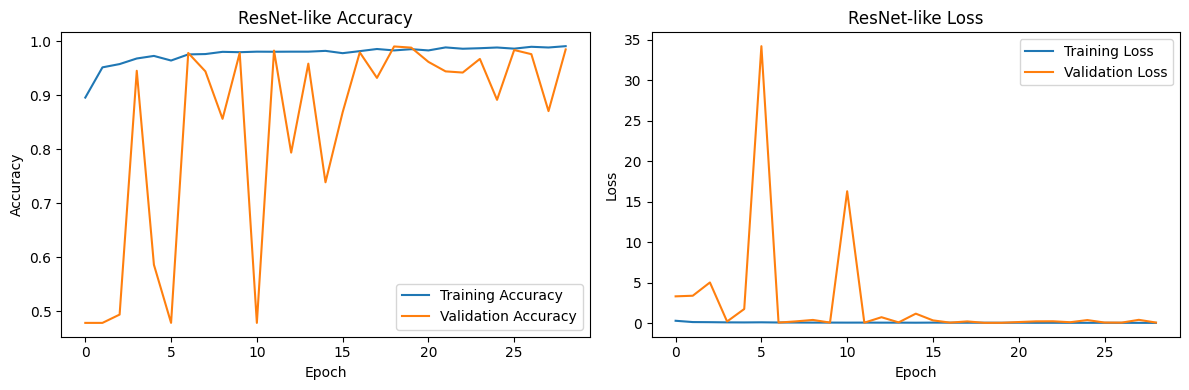

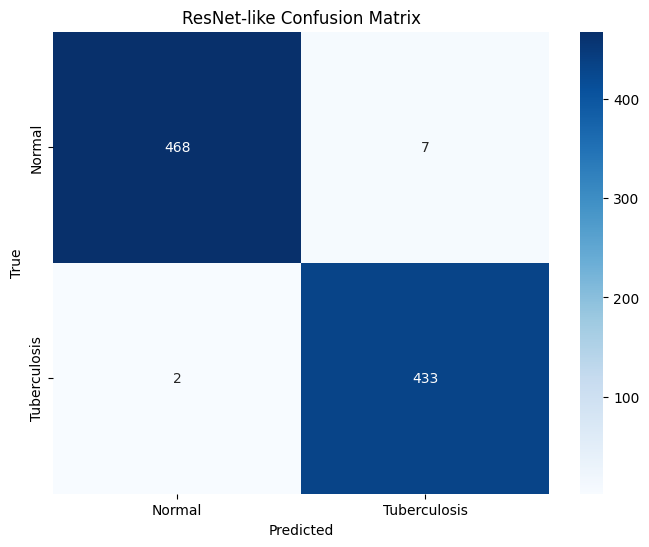

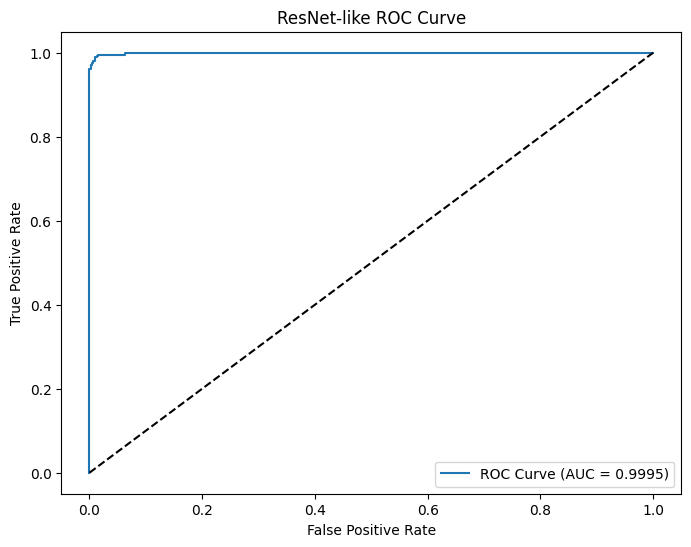

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training DenseNet-like model...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.7933 - loss: 1.1032 - val_accuracy: 0.4780 - val_loss: 2.0957
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9018 - loss: 0.3139 - val_accuracy: 0.6473 - val_loss: 2.5810
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9178 - loss: 0.2438 - val_accuracy: 0.7033 - val_loss: 0.5884
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9435 - loss: 0.1610 - val_accuracy: 0.6978 - val_loss: 3.5805
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9492 - loss: 0.1624 - val_accuracy: 0.7516 - val_loss: 4.0753
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9158 - loss: 0.2631 - val_accuracy: 0.7011 - val_loss: 2.7217
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8906 - loss: 0.3071 - val_accuracy: 0.7736 - val_loss: 0.8793
Epoch 8/50
191/191 ━━━━━

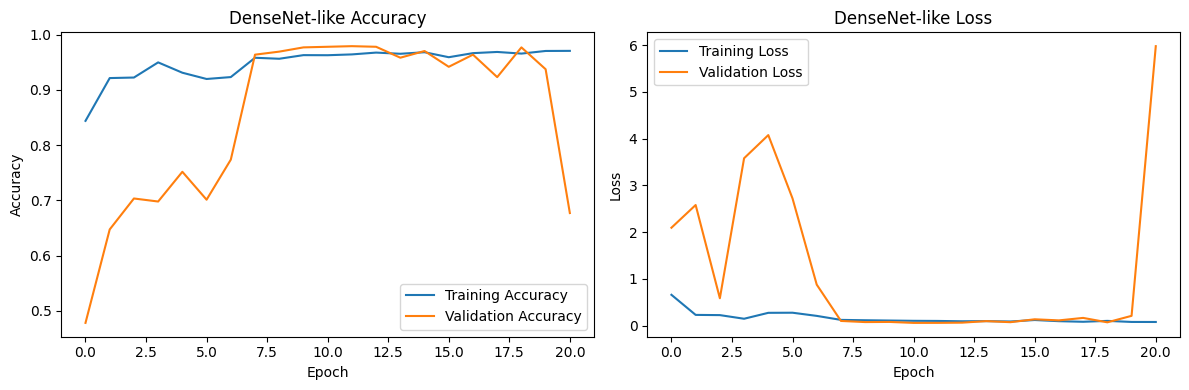

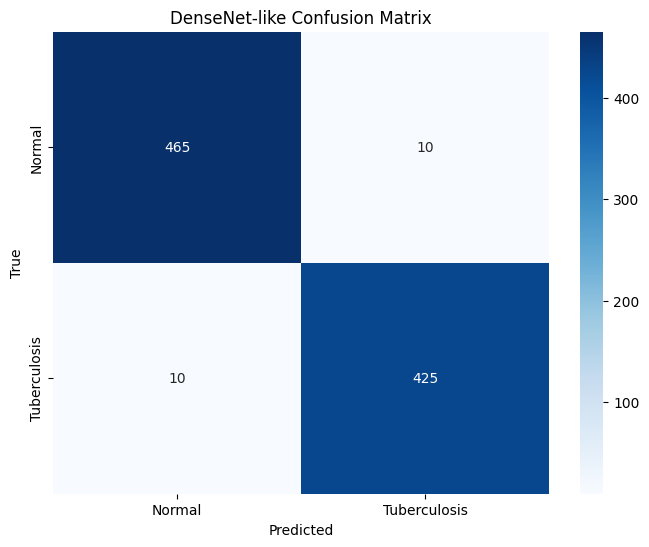

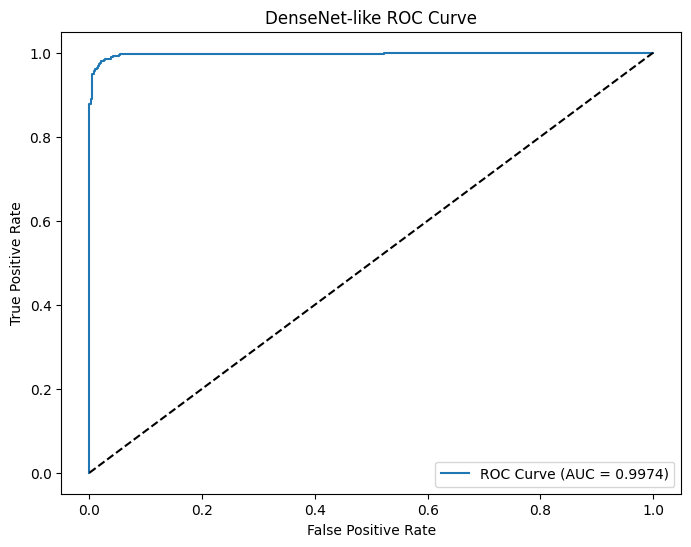

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training Inception-like model...
Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7529 - loss: 0.4680 - val_accuracy: 0.9055 - val_loss: 0.2220
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9153 - loss: 0.2094 - val_accuracy: 0.8923 - val_loss: 0.2794
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9080 - loss: 0.2431 - val_accuracy: 0.9495 - val_loss: 0.1395
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9451 - loss: 0.1466 - val_accuracy: 0.9648 - val_loss: 0.0912
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9505 - loss: 0.1344 - val_accuracy: 0.9747 - val_loss: 0.0678
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9647 - loss: 0.1019 - val_accuracy: 0.9769 - val_loss: 0.0672
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9649 - loss: 0.1059 - val_accuracy: 0.9769 - val_loss: 0.0642
Epoch 8/50
191/191 ━━━━━

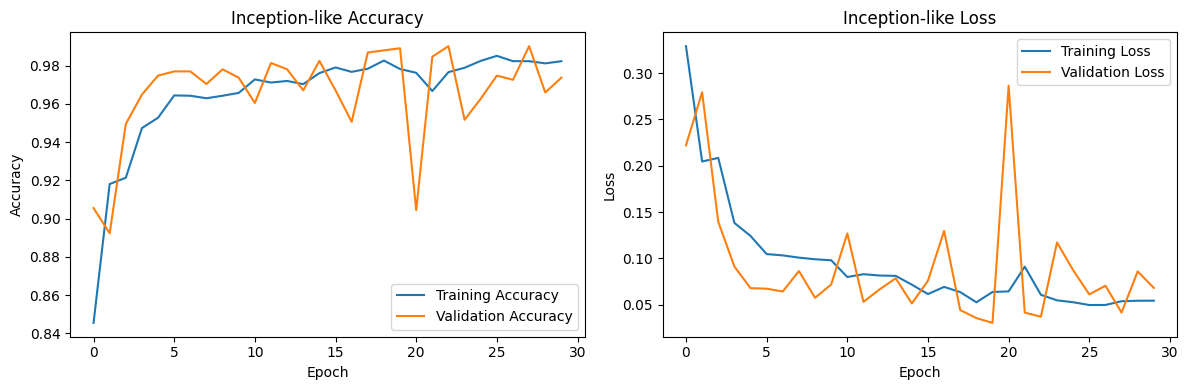

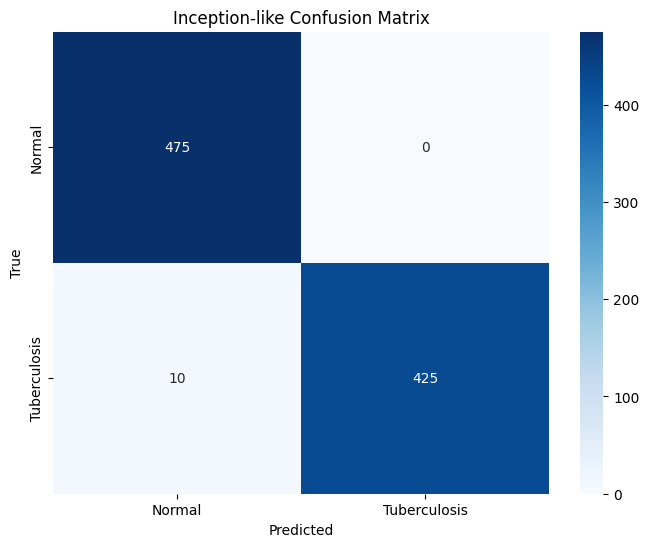

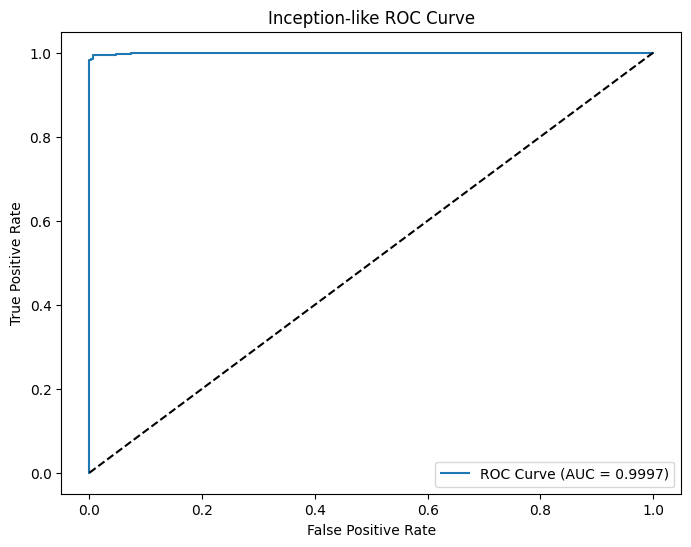

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [57]:
trained_models = {}
metrics = []

for model, name, model_type in models_to_train:
    print(f"\nTraining {name} model...")
    if model_type == "DL":
        trained_model, history, report, auc = train_and_evaluate_dl(model, name, X_train, y_train, X_test, y_test)
    else:
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        trained_model, report, auc = train_and_evaluate_ml(model, name, X_train_flat, y_train, X_test_flat, y_test)
    trained_models[name] = trained_model
    metrics.append({
        'Model': name,
        'F1-Score (Tuberculosis)': report['Tuberculosis']['f1-score'],
        'ROC AUC': auc,
        'Accuracy': accuracy_score(y_test, trained_model.predict(X_test) if model_type == "ML" else np.argmax(trained_model.predict(X_test), axis=1))
    })

In [69]:
def train_and_evaluate_ml(model, model_name, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a machine learning model.
    
    Parameters:
    - model: The ML model instance (e.g., RandomForestClassifier).
    - model_name: String name of the model (e.g., "Random Forest").
    - X_train: Training features (2D array).
    - y_train: Training labels.
    - X_test: Test features (2D array).
    - y_test: Test labels.
    
    Returns:
    - trained_model: The trained ML model.
    - report: Classification report as a dictionary.
    - auc_score: ROC AUC score.
    """
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability for the positive class
    
    # Calculate evaluation metrics
    report = classification_report(y_test, y_pred, target_names=['Normal', 'Tuberculosis'], output_dict=True)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Tuberculosis'], yticklabels=['Normal', 'Tuberculosis'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # 2. ROC Curve with precise AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')  # 4 decimal places
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print basic evaluation with precise AUC
    print(f"{model_name} trained successfully.")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"ROC AUC: {auc_score:.6f}")  # 6 decimal places
    
    return model, report, auc_score


Training Random Forest model...


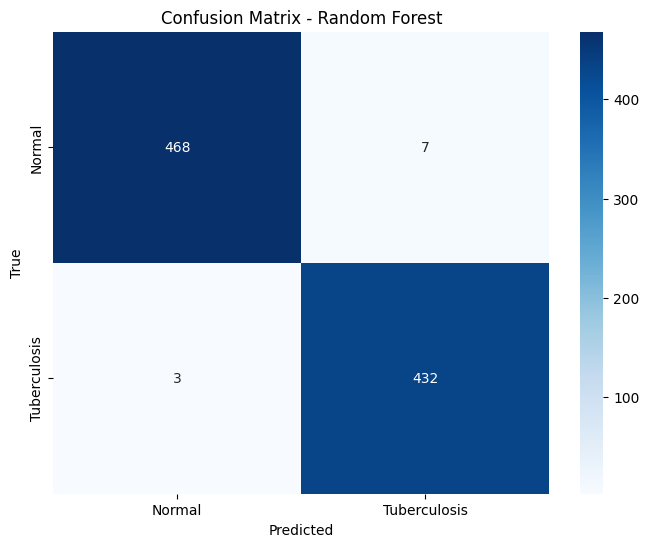

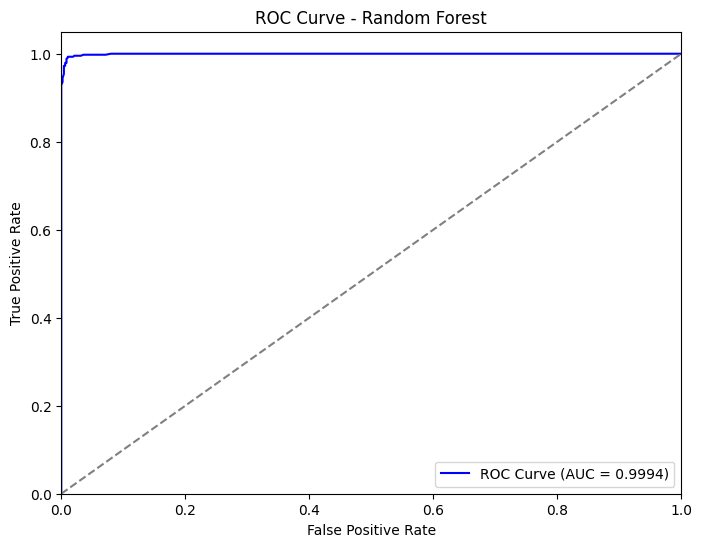

Random Forest trained successfully.
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       475
           1       0.98      0.99      0.99       435

    accuracy                           0.99       910
   macro avg       0.99      0.99      0.99       910
weighted avg       0.99      0.99      0.99       910

ROC AUC: 0.999402

Training XGBoost model...


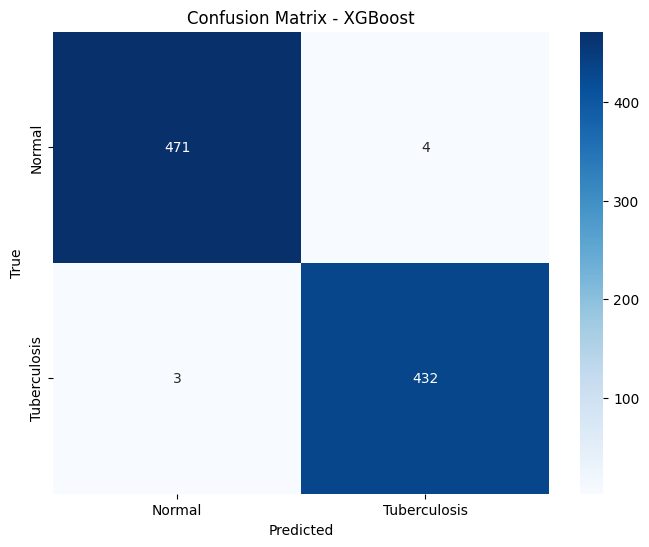

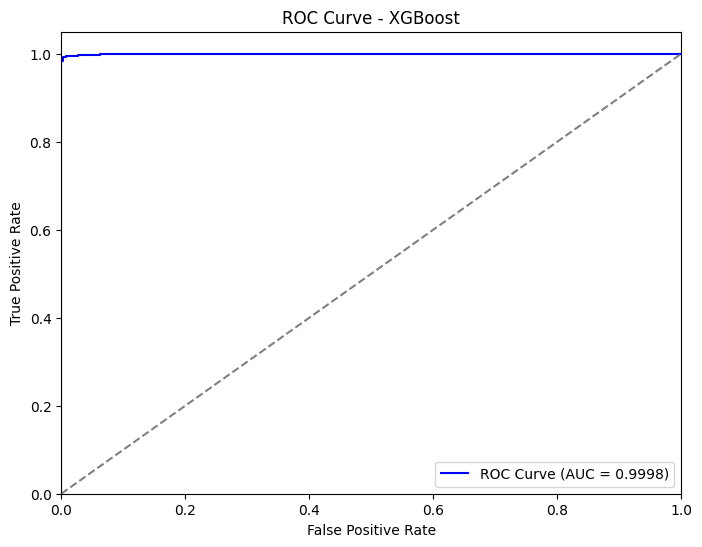

XGBoost trained successfully.
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       475
           1       0.99      0.99      0.99       435

    accuracy                           0.99       910
   macro avg       0.99      0.99      0.99       910
weighted avg       0.99      0.99      0.99       910

ROC AUC: 0.999753

Training SVM model...


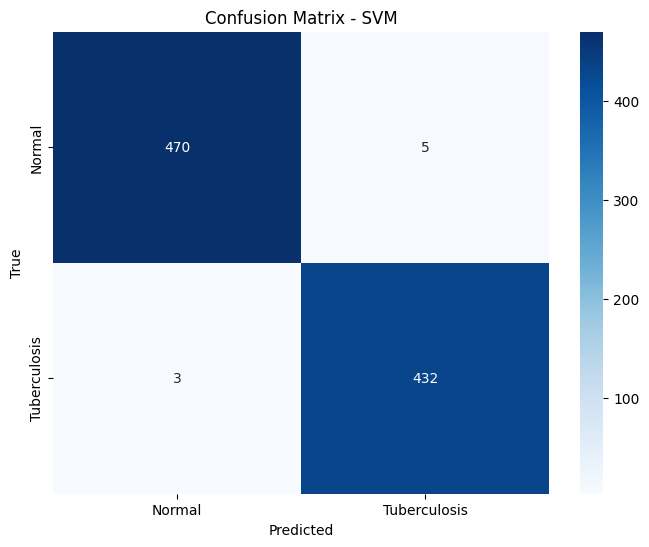

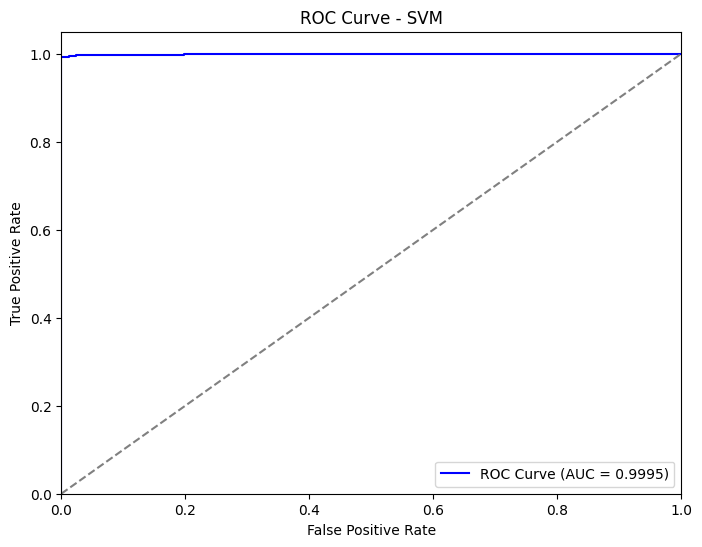

SVM trained successfully.
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       475
           1       0.99      0.99      0.99       435

    accuracy                           0.99       910
   macro avg       0.99      0.99      0.99       910
weighted avg       0.99      0.99      0.99       910

ROC AUC: 0.999463


In [70]:
# Initialize dictionaries and lists for ML models
trained_models_ml = {}
metrics_ml = []

# Train ML models
for model, name, _ in models_to_train_ml:  # Ignore model_type since all are "ML"
    print(f"\nTraining {name} model...")
    # Flatten the input data for ML models (from 4D to 2D)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    # Train and evaluate the ML model
    trained_model, report, auc = train_and_evaluate_ml(model, name, X_train_flat, y_train, X_test_flat, y_test)
    # Store the trained model
    trained_models_ml[name] = trained_model
    # Append metrics to the ML-specific list
    metrics_ml.append({
        'Model': name,
        'F1-Score (Tuberculosis)': report['Tuberculosis']['f1-score'],
        'ROC AUC': auc
    })

In [71]:
# Combine trained models into a single dictionary
trained_models_combined = {**trained_models, **trained_models_ml}

# Combine metrics into a single list
metrics_combined = metrics + metrics_ml

# Optional: Print combined results for verification
print("\nCombined Trained Models:")
for name in trained_models_combined:
    print(f"Model: {name}")

print("\nCombined Metrics:")
for metric in metrics_combined:
    print(f"Model: {metric['Model']}, F1-Score (Tuberculosis): {metric['F1-Score (Tuberculosis)']:.4f}, ROC AUC: {metric['ROC AUC']:.4f}")


Combined Trained Models:
Model: Simple CNN
Model: VGG-like
Model: ResNet-like
Model: DenseNet-like
Model: Inception-like
Model: Random Forest
Model: XGBoost
Model: SVM

Combined Metrics:
Model: Simple CNN, F1-Score (Tuberculosis): 0.9908, ROC AUC: 0.9994
Model: VGG-like, F1-Score (Tuberculosis): 0.9920, ROC AUC: 0.9995
Model: ResNet-like, F1-Score (Tuberculosis): 0.9897, ROC AUC: 0.9995
Model: DenseNet-like, F1-Score (Tuberculosis): 0.9770, ROC AUC: 0.9974
Model: Inception-like, F1-Score (Tuberculosis): 0.9884, ROC AUC: 0.9997
Model: Random Forest, F1-Score (Tuberculosis): 0.9886, ROC AUC: 0.9994
Model: XGBoost, F1-Score (Tuberculosis): 0.9920, ROC AUC: 0.9998
Model: SVM, F1-Score (Tuberculosis): 0.9908, ROC AUC: 0.9995


# Compare model performance


## Convert metrics to a DataFrame for easier plotting


In [72]:
metrics_df = pd.DataFrame(metrics_combined)


## 1. Bar Plot: Compare F1-Score and ROC AUC side by side


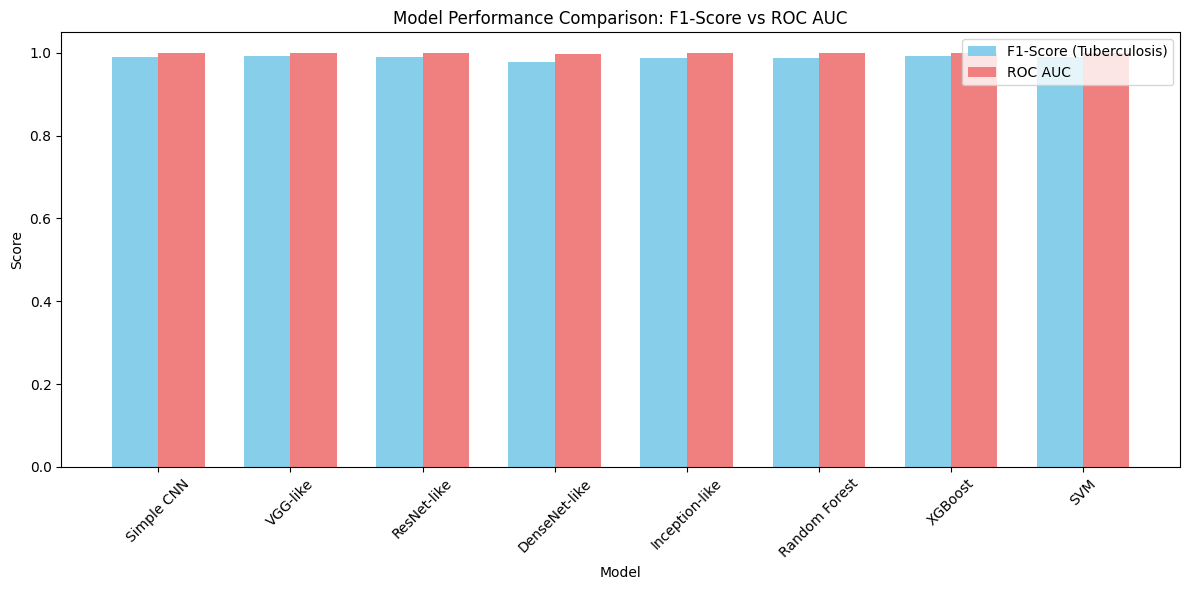

In [73]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(metrics_df))
plt.bar(index - bar_width/2, metrics_df['F1-Score (Tuberculosis)'], bar_width, label='F1-Score (Tuberculosis)', color='skyblue')
plt.bar(index + bar_width/2, metrics_df['ROC AUC'], bar_width, label='ROC AUC', color='lightcoral')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison: F1-Score vs ROC AUC')
plt.xticks(index, metrics_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Line Plot: Trends of F1-Score and ROC AUC across models


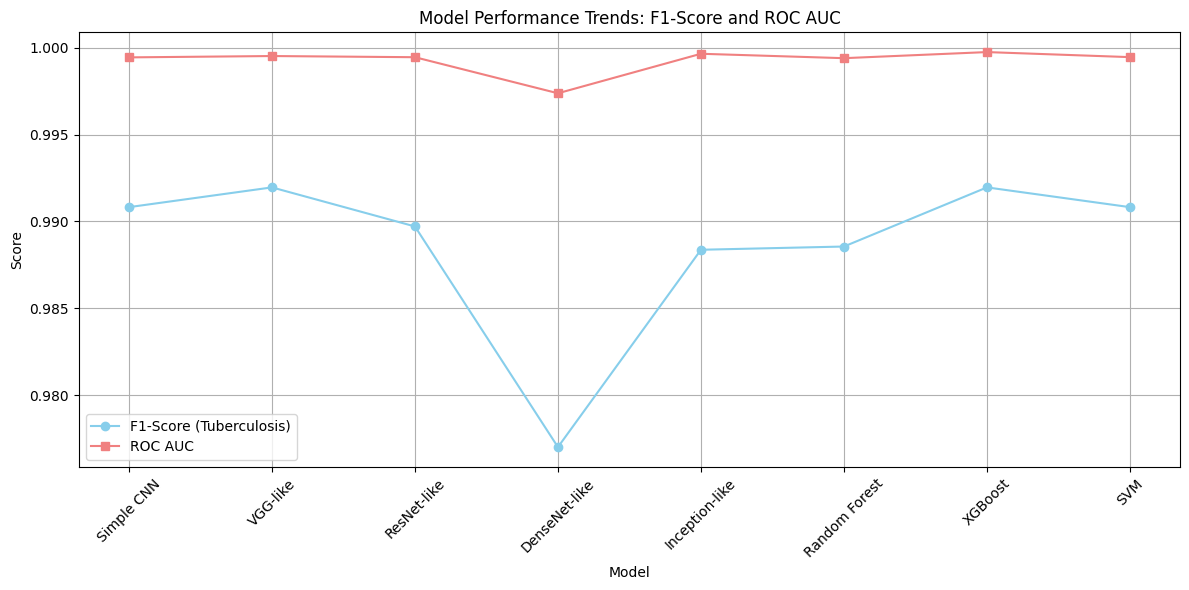

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['F1-Score (Tuberculosis)'], marker='o', label='F1-Score (Tuberculosis)', color='skyblue')
plt.plot(metrics_df['Model'], metrics_df['ROC AUC'], marker='s', label='ROC AUC', color='lightcoral')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Trends: F1-Score and ROC AUC')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Box Plot: Distribution of metrics (simplified for single metrics per model)

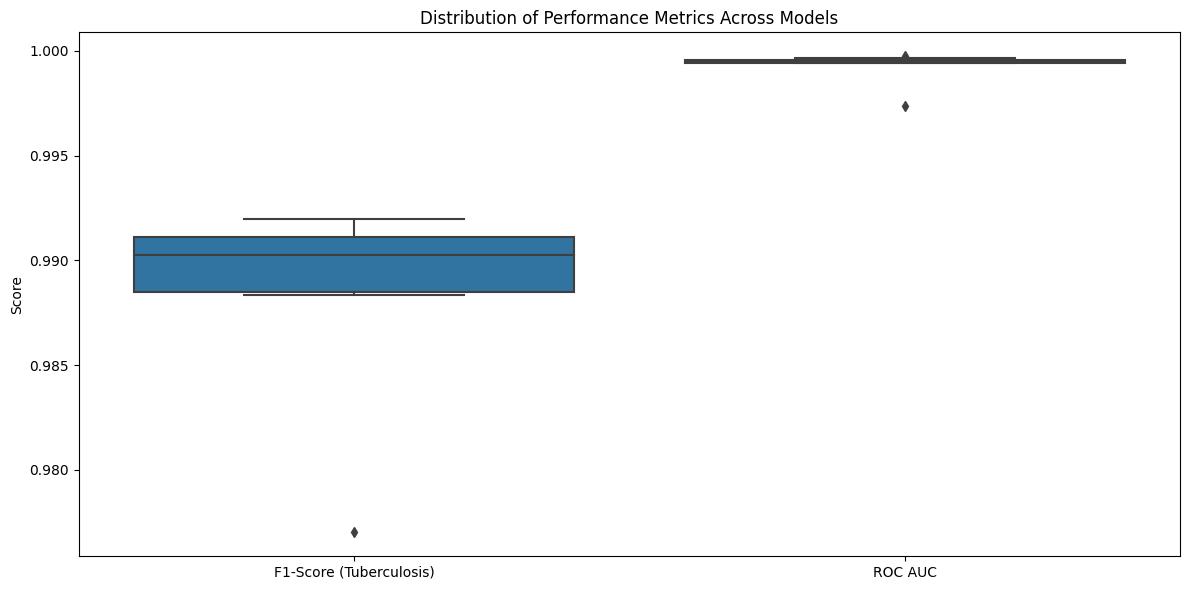

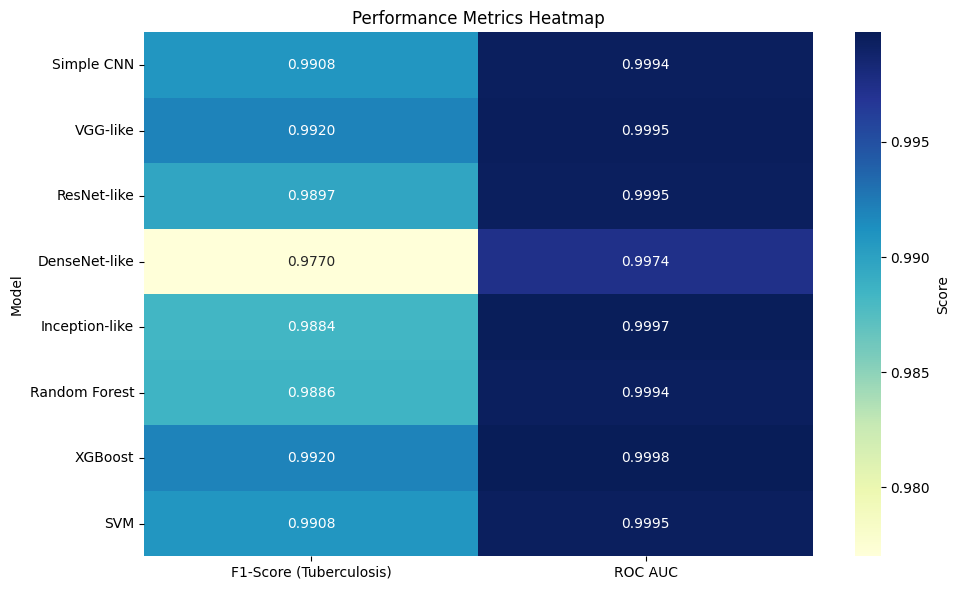

In [75]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df[['F1-Score (Tuberculosis)', 'ROC AUC']])
plt.title('Distribution of Performance Metrics Across Models')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# 4. Heatmap: Visual table of metrics
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df.set_index('Model')[['F1-Score (Tuberculosis)', 'ROC AUC']], 
            annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title('Performance Metrics Heatmap')
plt.tight_layout()
plt.show()

# Summary Table

In [76]:
print("\nSummary of Model Performance:")
print(metrics_df.to_string(index=False))


Summary of Model Performance:
         Model  F1-Score (Tuberculosis)  ROC AUC  Accuracy
    Simple CNN                 0.990826 0.999448  0.991209
      VGG-like                 0.991963 0.999526  0.992308
   ResNet-like                 0.989714 0.999458  0.990110
 DenseNet-like                 0.977011 0.997382  0.978022
Inception-like                 0.988372 0.999656  0.989011
 Random Forest                 0.988558 0.999402       NaN
       XGBoost                 0.991963 0.999753       NaN
           SVM                 0.990826 0.999463       NaN


# Select and save the best model based on F1-Score for Tuberculosis

In [81]:
import joblib
import pandas as pd
from tensorflow.keras.models import save_model

# Debug: Print keys to verify model storage
print("\nKeys in trained_models (DL):")
print(list(trained_models.keys()))
print("\nKeys in trained_models_ml:")
print(list(trained_models_ml.keys()))
print("\nModel names in metrics_combined:")
print([metric['Model'] for metric in metrics_combined])

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics_combined)

# Select the best model based on F1-Score (Tuberculosis), with ROC AUC as tie-breaker
best_model_info = metrics_df.loc[metrics_df['F1-Score (Tuberculosis)'].idxmax()]
if len(metrics_df[metrics_df['F1-Score (Tuberculosis)'] == best_model_info['F1-Score (Tuberculosis)']]) > 1:
    tied_models = metrics_df[metrics_df['F1-Score (Tuberculosis)'] == best_model_info['F1-Score (Tuberculosis)']]
    best_model_info = tied_models.loc[tied_models['ROC AUC'].idxmax()]

best_model_name = best_model_info['Model']
best_f1_score = best_model_info['F1-Score (Tuberculosis)']
best_roc_auc = best_model_info['ROC AUC']

# Print selection summary
print("\nBest Model Selection:")
print(f"Best Model: {best_model_name}")
print(f"F1-Score (Tuberculosis): {best_f1_score:.4f}")
print(f"ROC AUC: {best_roc_auc:.6f}")
print(f"Reason: Selected based on highest F1-Score (Tuberculosis). In case of a tie, highest ROC AUC was used as tie-breaker.")

# Save the best model with error handling
try:
    # Define ML model names
    ml_models = ['Random Forest', 'XGBoost', 'SVM']
    
    if best_model_name in ml_models:
        if best_model_name not in trained_models_ml:
            raise KeyError(f"Model '{best_model_name}' not found in trained_models_ml. Available ML models: {list(trained_models_ml.keys())}")
        joblib.dump(trained_models_ml[best_model_name], 'best_model_xgboost.pkl', compress=3)
        print(f"\nBest model saved as: best_model_xgboost.pkl")
    else:
        if best_model_name not in trained_models:
            raise KeyError(f"Model '{best_model_name}' not found in trained_models (DL). Available DL models: {list(trained_models.keys())}")
        save_model(trained_models[best_model_name], 'best_model.h5')
        print(f"\nBest model saved as: best_model.h5")
except KeyError as e:
    print(f"Error: {e}")
    print("Possible fixes:")
    print("1. Ensure model names in models_to_train_ml and models_to_train match those in metrics_combined.")
    print("2. Verify that all models were trained and stored correctly in trained_models or trained_models_ml.")
    print("3. Check the merge of trained_models_dl and trained_models_ml if applicable.")


Keys in trained_models (DL):
['Simple CNN', 'VGG-like', 'ResNet-like', 'DenseNet-like', 'Inception-like']

Keys in trained_models_ml:
['Random Forest', 'XGBoost', 'SVM']

Model names in metrics_combined:
['Simple CNN', 'VGG-like', 'ResNet-like', 'DenseNet-like', 'Inception-like', 'Random Forest', 'XGBoost', 'SVM']

Best Model Selection:
Best Model: XGBoost
F1-Score (Tuberculosis): 0.9920
ROC AUC: 0.999753
Reason: Selected based on highest F1-Score (Tuberculosis). In case of a tie, highest ROC AUC was used as tie-breaker.

Best model saved as: best_model_xgboost.pkl


# Model Selection Rationale: Why F1-Score (Tuberculosis), ROC AUC as Tie-Breaker, and XGBoost as Best Model?

## Context
This project involves binary classification of chest X-ray images (28x28 pixels) to detect tuberculosis (TB), with classes `Normal` (0) and `Tuberculosis` (1). The test set has 910 samples (475 Normal, 435 TB), indicating a relatively balanced dataset. Models evaluated include deep learning (DL) models (Simple CNN, VGG-like, ResNet-like, DenseNet-like, Inception-like) and machine learning (ML) models (Random Forest, XGBoost, SVM). The best model (XGBoost) was selected based on the highest F1-Score (Tuberculosis), with ROC AUC as the tie-breaker.

## Why F1-Score (Tuberculosis) as Primary Metric?
The **F1-Score (Tuberculosis)** was chosen as the primary metric for selecting the best model due to its alignment with the needs of TB detection:

1. **Balances Precision and Recall**:
   - **Precision** (TP / (TP + FP)): Measures the proportion of predicted TB cases that are correct, minimizing false positives (unnecessary treatments, patient distress, and healthcare costs).
   - **Recall** (TP / (TP + FN)): Measures the proportion of actual TB cases correctly identified, minimizing false negatives (missed diagnoses, critical due to TB’s contagious nature and potential for disease spread).
   - **F1-Score** (2 × (Precision × Recall) / (Precision + Recall)): The harmonic mean of precision and recall, ensuring a balance between avoiding missed TB cases and over-diagnosis. In medical diagnostics, both errors are costly, making F1-Score ideal.
   - Example: A model with high precision but low recall might miss TB cases, risking public health, while high recall with low precision could lead to over-diagnosis, straining resources.

2. **Handles Potential Class Imbalance**:
   - While the test set is balanced (475 Normal vs. 435 TB), real-world TB datasets (e.g., Montgomery County, Shenzhen) often have fewer TB cases. F1-Score focuses on the positive class (Tuberculosis), ensuring strong performance on the minority class, unlike accuracy, which can be inflated by predicting the majority class (Normal).
   - Example: Predicting all 910 samples as Normal yields ~52% accuracy but 0% recall for TB, rendering it useless for detection.

3. **Clinical Relevance**:
   - The F1-Score reflects the model’s ability to assist radiologists in accurately identifying TB cases for further review, optimizing both sensitivity (detecting TB) and specificity (avoiding false alarms). This is critical for clinical workflows where automated tools prioritize cases.

## Why ROC AUC as Tie-Breaker?
When VGG-like and XGBoost tied at F1-Score = 0.9920, **ROC AUC** was used to select XGBoost (0.999753 vs. 0.9995). Reasons:

1. **Complementary to F1-Score**:
   - F1-Score is computed at a specific threshold (e.g., 0.5 for ML models), reflecting performance at that operating condition. ROC AUC evaluates the model’s ability to rank positive (TB) instances higher than negative (Normal) instances across **all thresholds**.
   - A higher ROC AUC indicates better discriminative power, ensuring robustness if thresholds are adjusted (e.g., prioritizing recall for screening or precision for diagnosis).

2. **Production Robustness**:
   - In a Django backend, the model may need to operate at different thresholds based on clinical needs (e.g., high recall for population screening). XGBoost’s higher ROC AUC suggests better performance across varied scenarios, enhancing reliability in production.

3. **Holistic Performance**:
   - ROC AUC provides a comprehensive measure of class separation, complementing the F1-Score’s focus on a single threshold. This ensures the selected model is not only effective at the default threshold but also versatile for clinical applications.

## Why Not Other Metrics?
- **Accuracy**: Misleading in imbalanced datasets or when errors have high costs. Predicting all samples as Normal yields ~52% accuracy but fails to detect TB, unsuitable for medical tasks.
- **Precision**: Prioritizes minimizing false positives but may sacrifice recall, missing TB cases, which is riskier given TB’s public health impact.
- **Recall**: Prioritizes minimizing false negatives but may increase false positives, leading to over-diagnosis. F1-Score balances both for optimal performance.
- **Specificity** (TN / (TN + FP)): Focuses on correctly identifying Normal cases, less critical than detecting TB, as missing TB has worse consequences.
- **PR AUC**: A strong alternative for imbalanced datasets, but less common than ROC AUC. Since the test set is balanced, F1-Score is more actionable for a specific threshold, and ROC AUC suffices as a tie-breaker.

## Why XGBoost Stood Out?
XGBoost was selected as the best model (F1-Score: 0.9920, ROC AUC: 0.999753) for the following reasons:

1. **Top Performance**:
   - **F1-Score**: Tied with VGG-like at 0.9920, the highest among all models, indicating excellent balance between precision and recall for TB detection.
   - **ROC AUC**: Highest at 0.999753, slightly better than VGG-like (0.9995), suggesting superior discriminative ability across thresholds, critical for robust clinical performance.

2. **Computational Efficiency**:
   - As an ML model, XGBoost is significantly faster for inference than DL models like VGG-like, especially on CPU-based servers common in Django deployments. This reduces latency for real-time predictions on chest X-ray images, improving user experience in a web application.

3. **Model Simplicity and Size**:
   - XGBoost models are typically smaller than DL models (e.g., VGG-like), resulting in smaller file sizes when saved (e.g., `best_model_xgboost.pkl` vs. `.h5` files). This reduces storage needs and loading times in a Django backend.
   - Example: A `joblib` file for XGBoost is often a few MB, while DL models can be tens or hundreds of MB.

4. **Ease of Integration**:
   - Saved using `joblib` with compression (`compress=3`), XGBoost is optimized for Django integration. The `.pkl` file is easily loaded with `joblib.load()`, and its compatibility with scikit-learn pipelines simplifies preprocessing and inference.

5. **Robustness Across Datasets**:
   - XGBoost’s gradient boosting approach is less sensitive to overfitting on small datasets (e.g., 28x28 X-ray images) compared to complex DL models, which may require more data or tuning to generalize well. This makes XGBoost reliable for varied clinical datasets.

## Conclusion
The **F1-Score (Tuberculosis)** was chosen as the primary metric because it balances precision and recall, critical for minimizing missed TB cases and unnecessary treatments in medical diagnostics. **ROC AUC** was used as the tie-breaker for its comprehensive evaluation of discriminative ability across thresholds, ensuring robustness in a Django backend. **XGBoost** stood out due to its tied-highest F1-Score (0.9920), highest ROC AUC (0.999753), computational efficiency, smaller model size, and ease of integration, making it ideal for real-time TB detection in a web application. The model was saved as `best_model_xgboost.pkl` for efficient deployment.